In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms.functional as F


## 1.Get Data


### 1.Authenticate

In [2]:
# Step 1: Install Kaggle and Authenticate
!pip install kaggle
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

# files.upload()
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json

# Define the path to kaggle.json in Google Drive
kaggle_json_path = '/content/drive/MyDrive/ANPR/kaggle.json'

# Create the .kaggle directory
!mkdir -p ~/.kaggle

# Copy the kaggle.json file from Drive to the .kaggle directory
!cp {kaggle_json_path} ~/.kaggle/

# Set the permissions for kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.Download Dataset from Kaggle

In [3]:
# Step 2: Download Dataset from Kaggle
!kaggle datasets download -d andrewmvd/car-plate-detection
!unzip car-plate-detection.zip -d data/

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
License(s): CC0-1.0
 94% 191M/203M [00:01<00:00, 132MB/s]
100% 203M/203M [00:01<00:00, 128MB/s]
Archive:  car-plate-detection.zip
  inflating: data/annotations/Cars0.xml  
  inflating: data/annotations/Cars1.xml  
  inflating: data/annotations/Cars10.xml  
  inflating: data/annotations/Cars100.xml  
  inflating: data/annotations/Cars101.xml  
  inflating: data/annotations/Cars102.xml  
  inflating: data/annotations/Cars103.xml  
  inflating: data/annotations/Cars104.xml  
  inflating: data/annotations/Cars105.xml  
  inflating: data/annotations/Cars106.xml  
  inflating: data/annotations/Cars107.xml  
  inflating: data/annotations/Cars108.xml  
  inflating: data/annotations/Cars109.xml  
  inflating: data/annotations/Cars11.xml  
  inflating: data/annotations/Cars110.xml  
  inflating: data/annotations/Cars111.xml  
  inflating: data/annotations/Cars112.xml  
  inflating: data/annotations/Cars113.xml  
  inflati

### 3.Load random image for visualization

In [4]:
# Step 3: Load a Random Image
images_path = 'data/images/'
annotations_path = 'data/annotations/'
import random
import os

image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg') or f.endswith('.png')]
annotation_files = [f for f in os.listdir(annotations_path) if f.endswith('.xml')]

random_index = random.randint(0, len(image_files) - 1)
random_image_file = image_files[random_index]

image_base_name = os.path.splitext(random_image_file)[0]
random_annotation_file = f"{image_base_name}.xml"

In [5]:
if random_annotation_file not in annotation_files:
    raise FileNotFoundError(f"Annotation file {random_annotation_file} not found for image {random_image_file}")

image_path = os.path.join(images_path, random_image_file)
annotation_path = os.path.join(annotations_path, random_annotation_file)



In [6]:
# Step 4: Parse XML Annotation
tree = ET.parse(annotation_path)
root = tree.getroot()
bounding_boxes = []

In [7]:
for obj in root.findall('object'):
    bbox = obj.find('bndbox')
    xmin = int(float(bbox.find('xmin').text))
    ymin = int(float(bbox.find('ymin').text))
    xmax = int(float(bbox.find('xmax').text))
    ymax = int(float(bbox.find('ymax').text))
    bounding_boxes.append((xmin, ymin, xmax, ymax))

In [8]:
# Step 5: Draw Bounding Box on Image
import cv2

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for (xmin, ymin, xmax, ymax) in bounding_boxes:
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 255), 2)

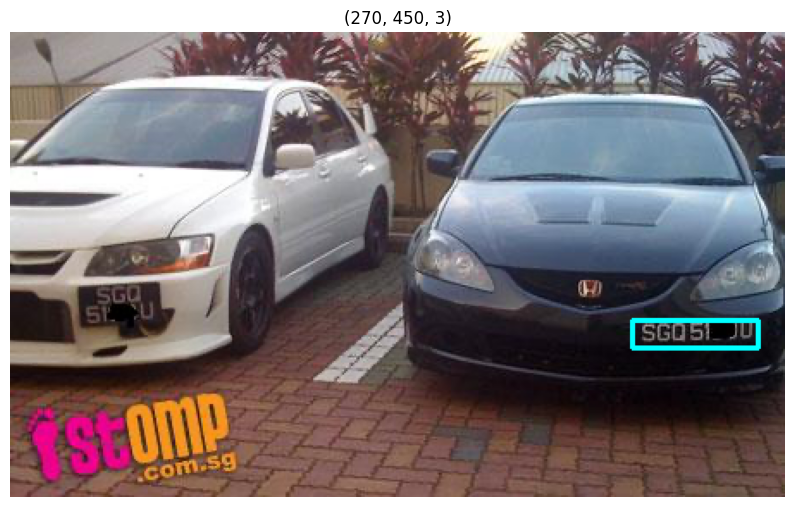

In [9]:
# Step 6: Display the Image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title(image.shape)
plt.axis('off')
plt.show()

## 2.Get the helper functions

In [10]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 4356 (delta 213), reused 254 (delta 178), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 23.15 MiB/s, done.
Resolving deltas: 100% (2585/2585), done.
Updating files: 100% (248/248), done.


In [11]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1.Make Train and Test Folders with specific data

In [12]:
import os
import shutil
import random
from tqdm.auto import tqdm

def create_train_test_split(data_folder, train_size_ratio=0.8):
    """
    Splits images and their corresponding annotation files into train and test folders.

    Parameters:
    - data_folder (str): Path to the folder containing 'images' and 'annotations' subfolders.
    - train_size_ratio (float): Proportion of data to use for training (default is 0.8).
    """

    # Define paths
    images_folder = os.path.join(data_folder, 'images')
    annotations_folder = os.path.join(data_folder, 'annotations')

    # Create train and test directories
    train_folder = os.path.join(data_folder, 'train')
    test_folder = os.path.join(data_folder, 'test')

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Get list of all image files
    image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Shuffle the image files to ensure randomness
    random.shuffle(image_files)

    # Calculate the number of training samples
    train_size = int(len(image_files) * train_size_ratio)

    # Split into train and test sets
    train_images = image_files[:train_size]
    test_images = image_files[train_size:]

    # Copy images and annotations to respective folders
    print(f"[INFO] Created {train_folder} for storing Train Images")
    for img in tqdm(train_images, desc= "Moving Train Images"):
        shutil.copy(os.path.join(images_folder, img), os.path.join(train_folder, img))
        annotation_file = img.rsplit('.', 1)[0] + '.xml'
        if os.path.exists(os.path.join(annotations_folder, annotation_file)):
            shutil.copy(os.path.join(annotations_folder, annotation_file), os.path.join(train_folder, annotation_file))


    print(f"\n[INFO] Created {test_folder} for storing Test Images")
    for img in tqdm(test_images, desc= "Moving Test Images"):
        shutil.copy(os.path.join(images_folder, img), os.path.join(test_folder, img))
        annotation_file = img.rsplit('.', 1)[0] + '.xml'
        if os.path.exists(os.path.join(annotations_folder, annotation_file)):
            shutil.copy(os.path.join(annotations_folder, annotation_file), os.path.join(test_folder, annotation_file))

# Example usage
create_train_test_split('data', train_size_ratio=0.8)

[INFO] Created data/train for storing Train Images


Moving Train Images:   0%|          | 0/346 [00:00<?, ?it/s]


[INFO] Created data/test for storing Test Images


Moving Test Images:   0%|          | 0/87 [00:00<?, ?it/s]

In [13]:
class NumberPlateDataset(Dataset):
    def __init__(self, img_dir, annotations_dir, transforms=None):
        self.img_dir = img_dir
        self.annotations_dir = annotations_dir
        self.transforms = transforms

        # List all image files
        self.imgs = [f for f in os.listdir(img_dir) if f.endswith('.jpeg') or f.endswith('.png')]

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # Get image file name
        img_name = self.imgs[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        # Get corresponding annotation file
        annotation_file = os.path.splitext(img_name)[0] + '.xml'
        annotation_path = os.path.join(self.annotations_dir, annotation_file)

        # Parse the .xml file
        boxes = []
        labels = []
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        for obj in root.findall('object'):
            # Get the label (assuming 'number_plate' is the label)
            label = obj.find('name').text
            labels.append(1)  # Assuming 'number_plate' is the only class and label is 1

            # Get bounding box coordinates
            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])

        # Convert everything into tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Additional fields required by PyTorch
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

        # Prepare target dictionary
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        # Apply transformations
        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target


In [14]:
# Initialize the dataset
dataset = NumberPlateDataset(
    img_dir='./data/images',
    annotations_dir='./data/annotations',
    transforms=None
)

# Test parsing of the first image and its annotations
img, target = dataset[0]
print(f"Image shape: {img.size}")
print("Bounding boxes:", target['boxes'])
print("Labels:", target['labels'])


Image shape: (400, 267)
Bounding boxes: tensor([[118., 199., 153., 211.]])
Labels: tensor([1])


In [15]:
# Custom transformations
class Resize(object):
    def __init__(self, min_size, max_size):
        self.min_size = min_size
        self.max_size = max_size

    def __call__(self, image, target):
        # Get original image size
        w, h = image.size

        # Calculate resize scale
        im_shape = np.array([h, w])
        min_im_size = np.min(im_shape)
        max_im_size = np.max(im_shape)
        scale = self.min_size / min_im_size

        # Prevent the bigger axis from being more than max_size
        if np.round(scale * max_im_size) > self.max_size:
            scale = self.max_size / max_im_size

        # Resize the image
        image = F.resize(image, [int(h * scale), int(w * scale)])

        # Resize bounding boxes
        target = target.copy()
        target['boxes'] = target['boxes'] * scale

        return image, target

class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class RandomHorizontalFlip(object):
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if np.random.rand() < self.prob:
            image = F.hflip(image)
            w, _ = image.size
            boxes = target['boxes']
            boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
            target['boxes'] = boxes
        return image, target

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

def get_transform(train):
    transforms = []
    transforms.append(Resize(min_size=224, max_size=224))
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    transforms.append(ToTensor())
    return Compose(transforms)


In [37]:
# Dataset and DataLoader
dataset = NumberPlateDataset(
    img_dir='./data/images',
    annotations_dir='./data/annotations',
    transforms=get_transform(train=True)
)

dataset_test = NumberPlateDataset(
    img_dir='./data/images',
    annotations_dir='./data/annotations',
    transforms=get_transform(train=False)
)

# Split dataset into training and validation sets
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
dataset_train, dataset_val = random_split(dataset, [train_size, val_size])

# Data loaders
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    dataset_train,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    dataset_val,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    dataset_test,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

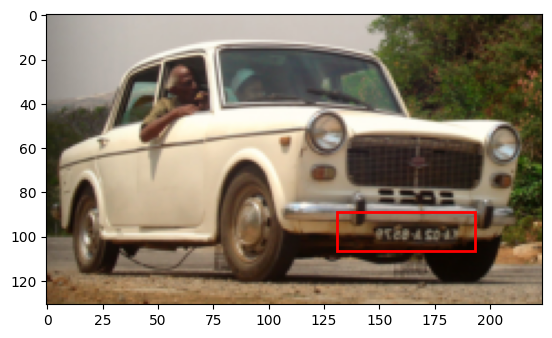

In [17]:
import matplotlib.patches as patches

def visualize_sample(idx):
    img, target = dataset[idx]
    img_np = img.mul(255).permute(1, 2, 0).byte().numpy()
    fig, ax = plt.subplots(1)
    ax.imshow(img_np)

    boxes = target['boxes']
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
    plt.show()

# Visualize the first sample
visualize_sample(88)


In [18]:
# Assuming 'train_loader' is your DataLoader instance
dataiter = iter(train_loader)
images, targets = next(dataiter)

In [19]:
# Extract the first image and its target from the batch
image = images[0]
target = targets[0]


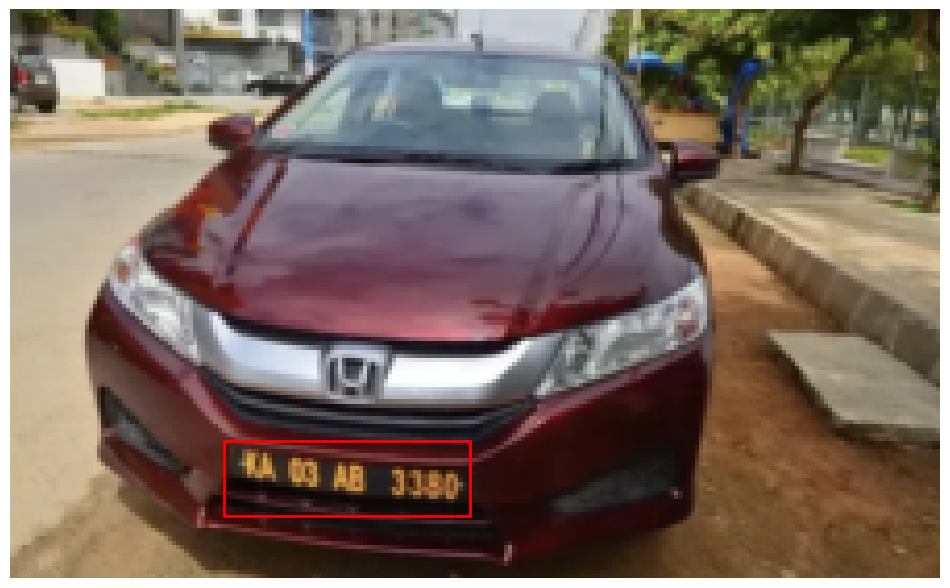

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_image(image, target):
    # Convert the tensor image to a NumPy array
    img_np = image.mul(255).permute(1, 2, 0).byte().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img_np)

    # Get the bounding boxes from the target
    boxes = target['boxes']

    # Iterate over all bounding boxes and plot them
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)

    plt.axis('off')  # Hide axis
    plt.show()

# Visualize the extracted image and its annotations
visualize_image(image, target)


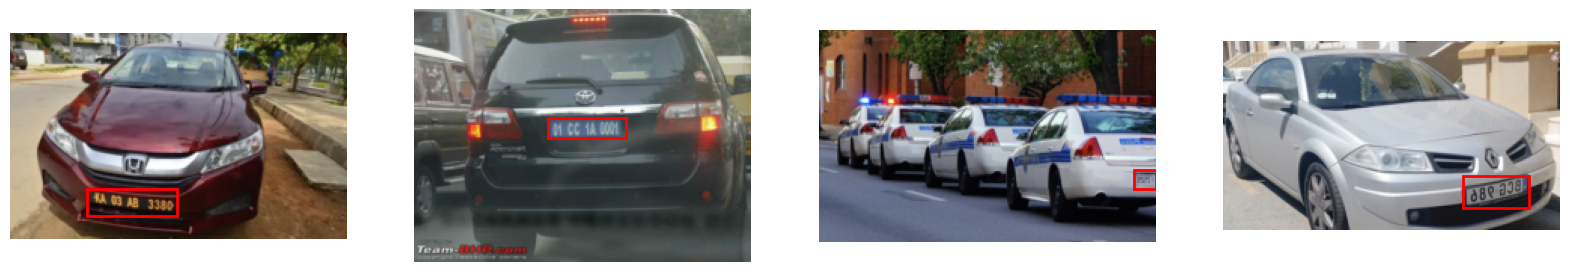

In [21]:
def visualize_batch(images, targets, num_images=4):
    num_images = min(num_images, len(images))
    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 5, 5))

    for idx in range(num_images):
        image = images[idx]
        target = targets[idx]
        img_np = image.mul(255).permute(1, 2, 0).byte().numpy()
        ax = axs[idx]
        ax.imshow(img_np)

        boxes = target['boxes']
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=2,
                edgecolor='red',
                facecolor='none'
            )
            ax.add_patch(rect)
        ax.axis('off')
    plt.show()

# Visualize the first 4 images in the batch
visualize_batch(images, targets, num_images=4)


In [22]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.optim import SGD
from torch.utils.data import DataLoader


In [31]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load the pretrained Faster R-CNN model
def get_model(num_classes):
    # Load the pre-trained Faster R-CNN model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Replace the classifier with a new one, suitable for our dataset
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Define the number of classes (1 class for number plate + background)
num_classes = 2
model = get_model(num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN

# Define optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [33]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms.functional as F
from torchvision.ops import box_iou
from tqdm import tqdm

# Training loop
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    loss_sum = 0
    for images, targets in tqdm(data_loader, desc=f"Epoch {epoch}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_sum += losses.item()

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    return loss_sum / len(data_loader)


In [34]:
from torchvision.models.detection import FasterRCNN

@torch.no_grad()
def evaluate(model, data_loader, device):
    model.eval()
    total_boxes = 0
    total_correct_boxes = 0

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i, output in enumerate(outputs):
            pred_boxes = output['boxes'].cpu().numpy()
            true_boxes = targets[i]['boxes'].cpu().numpy()
            ious = box_iou(torch.tensor(pred_boxes), torch.tensor(true_boxes))

            # Threshold IOU as needed for metric
            total_correct_boxes += (ious.max(dim=1)[0] > 0.5).sum().item()
            total_boxes += len(true_boxes)

    accuracy = total_correct_boxes / total_boxes
    return accuracy


In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    val_accuracy = evaluate(model, val_loader, device)

    # Adjust learning rate
    lr_scheduler.step()

    print(f"Epoch {epoch}: Loss={train_loss:.4f}, Validation Accuracy={val_accuracy:.4f}")


Epoch 0: 100%|██████████| 87/87 [01:46<00:00,  1.23s/it]


Epoch 0: Loss=0.1642, Validation Accuracy=1.3556


Epoch 1: 100%|██████████| 87/87 [01:47<00:00,  1.23s/it]


Epoch 1: Loss=0.0988, Validation Accuracy=1.1111


Epoch 2: 100%|██████████| 87/87 [01:46<00:00,  1.22s/it]


Epoch 2: Loss=0.0875, Validation Accuracy=1.0333


Epoch 3: 100%|██████████| 87/87 [01:46<00:00,  1.22s/it]


Epoch 3: Loss=0.0731, Validation Accuracy=1.0556


Epoch 4: 100%|██████████| 87/87 [01:46<00:00,  1.22s/it]


Epoch 4: Loss=0.0705, Validation Accuracy=1.0111


Epoch 5: 100%|██████████| 87/87 [01:46<00:00,  1.22s/it]


Epoch 5: Loss=0.0697, Validation Accuracy=1.0444


Epoch 6: 100%|██████████| 87/87 [01:46<00:00,  1.23s/it]


Epoch 6: Loss=0.0686, Validation Accuracy=1.0667


Epoch 7: 100%|██████████| 87/87 [01:46<00:00,  1.23s/it]


Epoch 7: Loss=0.0676, Validation Accuracy=1.0556


Epoch 8: 100%|██████████| 87/87 [01:47<00:00,  1.23s/it]


Epoch 8: Loss=0.0683, Validation Accuracy=1.0667


Epoch 9: 100%|██████████| 87/87 [01:47<00:00,  1.23s/it]


Epoch 9: Loss=0.0677, Validation Accuracy=1.0778


In [38]:
test_accuracy = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 1.1125


In [39]:
# Define the path to save the model in Google Drive
save_path = "/content/drive/My Drive/ANPR/number_plate_detection.pth"

# Save the model
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")


Model saved to /content/drive/My Drive/ANPR/number_plate_detection.pth


In [41]:
# Load weights
model.load_state_dict(torch.load("/content/drive/My Drive/ANPR/number_plate_detection.pth"))
model.eval()

# Inference
@torch.no_grad()
def predict(image, model, device):
    image = [image.to(device)]
    outputs = model(image)
    return outputs[0]  # Predictions for the single image


<ipython-input-41-8c9e4f87ee70>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/My Drive/ANPR/number_plate_detection.pth"))

<ipython-input-52-86809f4584f2>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/My Drive/ANPR/number_plate_detection.pth"))

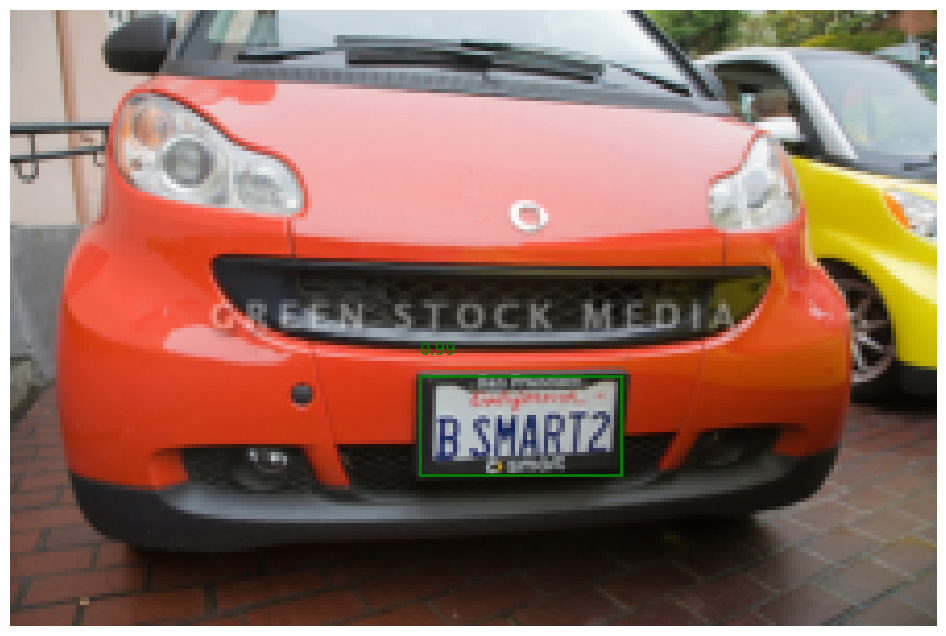

In [52]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F

# Load the model and set to evaluation mode
model.load_state_dict(torch.load("/content/drive/My Drive/ANPR/number_plate_detection.pth"))
model.eval()
model.to(device)

# Function to visualize predictions
def visualize_prediction(image, prediction, threshold=0.5):
    # Convert the tensor image to a NumPy array
    img_np = image.mul(255).permute(1, 2, 0).byte().cpu().numpy()

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img_np)

    # Get the bounding boxes and scores from predictions
    boxes = prediction['boxes'].cpu().detach().numpy()
    scores = prediction['scores'].cpu().detach().numpy()

    # Iterate over all bounding boxes and plot those above the threshold
    for box, score in zip(boxes, scores):
        if score >= threshold:
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=2,
                edgecolor='green',
                facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(xmin, ymin - 5, f"{score:.2f}", color='green', fontsize=12)

    plt.axis('off')  # Hide axis
    plt.show()

# Select a random image from the test dataset
idx = random.randint(0, len(dataset_test) - 1)
image, target = dataset_test[idx]

# Move the image to the device and make predictions
image = image.to(device)
output = model([image])[0]

# Visualize the result
visualize_prediction(image, output)
